## Annotate `'msk_impact_2017'` study's mutation endpoints from cBioPortal using OncoKB REST API.

First import `bravado` and `pandas`.

Initialize REST APIs for cBioPortal and OncoKB.

In [5]:
from bravado.client import SwaggerClient
from pprint import pprint
from copy import *

import matplotlib
import pandas

%matplotlib inline

plot_w, plot_h = matplotlib.rcParams['figure.figsize']

cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/api-docs',
                                config={"validate_requests":False,"validate_responses":False})

oncokb = SwaggerClient.from_url('https://www.oncokb.org/api/v1/v2/api-docs',
                                config={"validate_requests":False,"validate_responses":False})

Pick the study with the highest sample count (`'msk_impact_2017'`):

In [6]:
studies = cbioportal.B_Studies.getAllStudiesUsingGET().result()
sorted_studies = sorted(studies, key=lambda x: x.allSampleCount)

assert sorted_studies[-1].studyId == 'msk_impact_2017', 'studies has been updated?'

Retrieve all available clinical data in `'msk_impact_2017'` study:

In [7]:
msk_clinical_data=cbioportal.G_Clinical_Data.getAllClinicalDataInStudyUsingGET(studyId='msk_impact_2017').result()

The clinical data returned from `getAllClinicalDataInStudyUsingGET()` can be inserted into a DataFrame.

In [9]:
%%time

parsed_clinical_data = dict()
for cd in msk_clinical_data:
    if cd.uniqueSampleKey not in parsed_clinical_data:
        parsed_clinical_data[cd.uniqueSampleKey] = dict()
        parsed_clinical_data[cd.uniqueSampleKey]['uniqueSampleKey'] = cd.uniqueSampleKey
        parsed_clinical_data[cd.uniqueSampleKey][cd.clinicalAttributeId] = cd.value
        parsed_clinical_data[cd.uniqueSampleKey]['patientId'] = cd.patientId
        parsed_clinical_data[cd.uniqueSampleKey]['sampleId'] = cd.sampleId
        parsed_clinical_data[cd.uniqueSampleKey]['studyId'] = cd.studyId
        parsed_clinical_data[cd.uniqueSampleKey]['uniquePatientKey'] = cd.uniquePatientKey
    else:
        parsed_clinical_data[cd.uniqueSampleKey][cd.clinicalAttributeId] = cd.value

cd_df = pandas.DataFrame.from_dict([cd[1] for cd in parsed_clinical_data.items()])

CPU times: user 570 ms, sys: 5.22 ms, total: 575 ms
Wall time: 575 ms


In [10]:
print("number of clinical data endpoints:", len(parsed_clinical_data))

number of clinical data endpoints: 10945


Here, the study samples can be categorized under `'CANCER_TYPE'`.

In [11]:
msk_clinical_data_sorted_cancer_type = cd_df.groupby('CANCER_TYPE')['uniqueSampleKey'].nunique().sort_values(ascending=False)

Here is a plot of the studies' samples sorted by `'CANCER_TYPE'`:

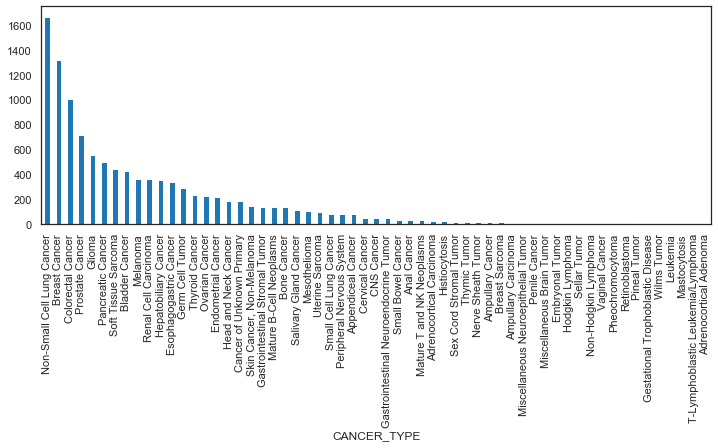

In [43]:
msk_clinical_data_sorted_cancer_type.plot(kind='bar', figsize=(2*plot_w, plot_h))

Obtain mutations for `'msk_impact_2017'`:

In [13]:
%%time

mutations = cbioportal.K_Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
    molecularProfileId='msk_impact_2017_mutations',
    sampleListId='msk_impact_2017_all',
    projection='DETAILED'
).result()

CPU times: user 11.4 s, sys: 340 ms, total: 11.8 s
Wall time: 15.6 s


Combine `'msk_impact_2017'` clinical data endpoints with `'msk_impact_2017'` mutations endpoints.

Obtain the set of mutation entrez gene IDs (this makes it easier to count the total number of `entrezGeneId`s):

In [16]:
mutations_entrezGeneId = set()
for m in mutations:
    mutations_entrezGeneId.add(m.entrezGeneId)

print("There are {0} `'msk_impact_2017'` mutation entrez gene IDs!".format(len(mutations_entrezGeneId)))

There are 1162 `'msk_impact_2017'` mutation entrez gene IDs!


Use gene mutation ID and proteinChange to filter OncoKB's Annotations:

In [18]:
msk_cd_with_mutations = deepcopy(parsed_clinical_data)
for m in mutations:
    if 'mutations' not in msk_cd_with_mutations[m.uniqueSampleKey]:
        msk_cd_with_mutations[m.uniqueSampleKey]['mutations'] = []
    msk_cd_with_mutations[m.uniqueSampleKey]['mutations'].append(m)

print("There are {0} `'msk_impact_2017'` study samples without mutations.\n".format(len([kv[1] for kv in msk_cd_with_mutations.items() if ('mutations' not in kv[1])])))
print("Total number of mutations in `'msk_impact_2017'` study:", len(mutations))

There are 667 `'msk_impact_2017'` study samples without mutations.

Total number of mutations in `'msk_impact_2017'` study: 81217


## Requesting annotations for all `'msk_impact_2017'` study mutations (might take ~21-22 minutes)!

In [32]:
%%time

msk_mutation_annotations = []
for m in mutations:
    msk_mutation_annotations.append((m,
        oncokb.Annotations.annotateMutationsByProteinChangeGetUsingGET(entrezGeneId=m.entrezGeneId, alteration=m.proteinChange).result()))

assert len(msk_mutation_annotations) == len(mutations), "some annotation requests failed"

CPU times: user 4min 42s, sys: 30.8 s, total: 5min 13s
Wall time: 27min 17s


In [33]:
msk_mutation_annotations[0]

(Mutation(aminoAcidChange=None, center='NA', driverFilter='', driverFilterAnnotation='', driverTiersFilter='', driverTiersFilterAnnotation='', endPosition=36252995, entrezGeneId=861, fisValue=1.4013e-45, functionalImpactScore='[Not Available]', gene=Gene(chromosome='21', cytoband='21q22.12', entrezGeneId=861, hugoGeneSymbol='RUNX1', length=261534, type='protein-coding'), keyword='RUNX1 truncating', linkMsa='[Not Available]', linkPdb='[Not Available]', linkXvar='[Not Available]', molecularProfileId='msk_impact_2017_mutations', mutationStatus='NA', mutationType='Frame_Shift_Ins', ncbiBuild='GRCh37', normalAltCount=None, normalRefCount=None, patientId='P-0008845', proteinChange='D96Gfs*11', proteinPosEnd=96, proteinPosStart=96, referenceAllele='NA', refseqMrnaId='NM_001001890.2', sampleId='P-0008845-T01-IM5', startPosition=36252994, studyId='msk_impact_2017', tumorAltCount=98, tumorRefCount=400, uniquePatientKey='UC0wMDA4ODQ1Om1za19pbXBhY3RfMjAxNw', uniqueSampleKey='UC0wMDA4ODQ1LVQwMS1JTT

In [34]:
msk_annotated_mutation_cancer_types = [
    {**m[0].__dict__['_Model__dict'],
    **m[1].__dict__['_Model__dict'],
    **{'CANCER_TYPE': parsed_clinical_data[m[0].uniqueSampleKey]['CANCER_TYPE']}}
    for m in msk_mutation_annotations]

Filter `'msk_impact_2017'` study mutations by `'LEVEL_1'`:

Text(0.5, 1.0, 'LEVEL_1')

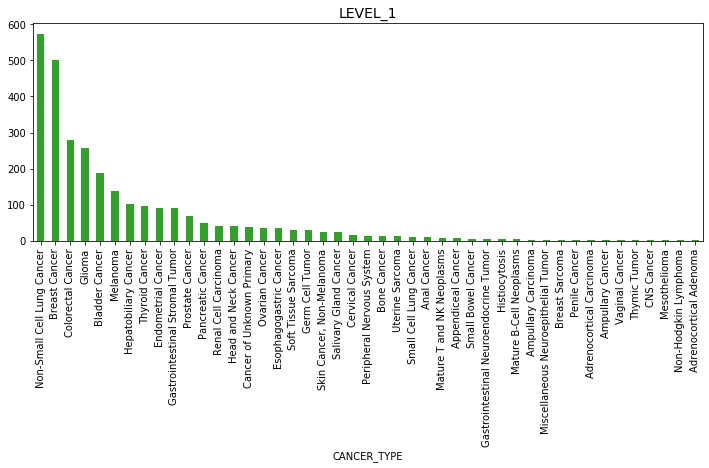

In [40]:
msk_annotated_mutation_cancer_types_level_1 = [am for am in msk_annotated_mutation_cancer_types if am['highestSensitiveLevel'] == 'LEVEL_1']
annotations_level_1_df = pandas.DataFrame.from_dict(msk_annotated_mutation_cancer_types_level_1)
annotations_level_1_df.groupby('CANCER_TYPE')['uniqueSampleKey'].nunique().sort_values(ascending=False).plot(kind='bar', figsize=(2*plot_w, plot_h), color='#33A02C').set_title('LEVEL_1', fontsize=14)

Filter `'msk_impact_2017'` study mutations by `'LEVEL_2A'`:

Text(0.5, 1.0, 'LEVEL_2A')

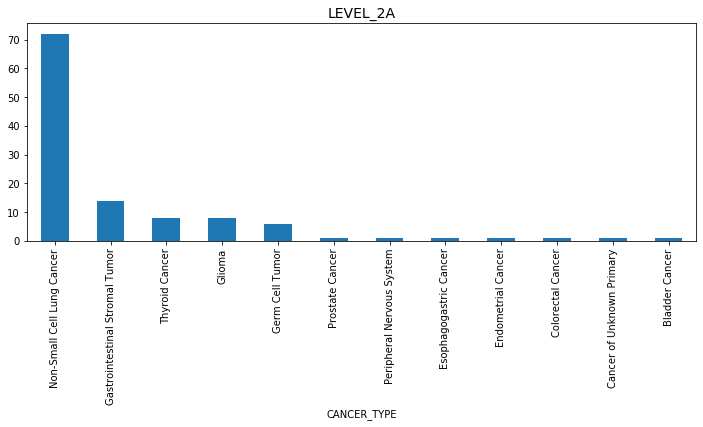

In [41]:
msk_annotated_mutation_cancer_types_level_2a = [am for am in msk_annotated_mutation_cancer_types if am['highestSensitiveLevel'] == 'LEVEL_2A']

annotations_level_2a_df = pandas.DataFrame.from_dict(msk_annotated_mutation_cancer_types_level_2a)
annotations_level_2a_df.groupby('CANCER_TYPE')['uniqueSampleKey'].nunique().sort_values(ascending=False).plot(kind='bar', figsize=(2*plot_w, plot_h), color='#1F78B4').set_title('LEVEL_2A', fontsize=14)


Filter `'msk_impact_2017'` study mutations by `'VUS'`:

Text(0.5, 1.0, 'VUS')

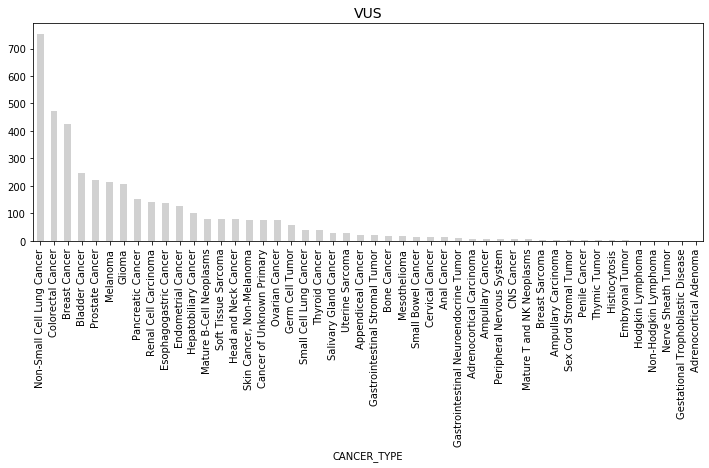

In [38]:
msk_annotated_mutation_cancer_types_vus = [am for am in msk_annotated_mutation_cancer_types if ((not (am['vus'] is None)) and am['vus'])]

annotations_vus_df = pandas.DataFrame.from_dict(msk_annotated_mutation_cancer_types_vus)
annotations_vus_df.groupby('CANCER_TYPE')['uniqueSampleKey'].nunique().sort_values(ascending=False).plot(kind='bar', figsize=(2*plot_w, plot_h), color='#d1d1d1').set_title('VUS', fontsize=14)


## Requesting annotations for only `'Non-Small Cell Lung Cancer'` mutations in `'msk_impact_2017'`.

In [19]:
msk_clinical_data_nsclc = [kv[1] for kv in msk_cd_with_mutations.items() if (kv[1]['CANCER_TYPE'] == 'Non-Small Cell Lung Cancer')]
msk_clinical_data_nsclc_set = set()
for cd_nsclc in msk_clinical_data_nsclc:
    if 'mutations' in cd_nsclc:
        for m in cd_nsclc['mutations']:
            msk_clinical_data_nsclc_set.add((m.entrezGeneId, m.proteinChange))
print("Total number of `'Non-Small Cell Lung Cancer'` mutations in `'msk_impact_2017'` study:", len(msk_clinical_data_nsclc_set))

Total number of `'Non-Small Cell Lung Cancer'` mutations in `'msk_impact_2017'` study: 11181


The requests may take ~3-4 minutes.

In [21]:
%%time

msk_clinical_data_nsclc_annotations = []
for a in msk_clinical_data_nsclc_set:
    msk_clinical_data_nsclc_annotations.append(
        oncokb.Annotations.annotateMutationsByProteinChangeGetUsingGET(entrezGeneId=a[0], alteration=a[1]).result())


CPU times: user 39.2 s, sys: 4.23 s, total: 43.5 s
Wall time: 3min 54s


In [23]:
msk_clinical_data_nsclc_annotations[0].__dict__['_Model__dict']

{'alleleExist': False,
 'dataVersion': 'v1.20',
 'diagnosticImplications': None,
 'diagnosticSummary': '',
 'geneExist': True,
 'geneSummary': 'MED12 is a component of CDK8, a subcomplex involved in transcription initiation. MED12 plays a role in the genesis of benign tumors such as uterine leiomyoma and breast fibroadenoma and is altered in a variety of estrogen-dependent tumors.',
 'highestDiagnosticImplicationLevel': None,
 'highestPrognosticImplicationLevel': None,
 'highestResistanceLevel': None,
 'highestSensitiveLevel': None,
 'hotspot': False,
 'lastUpdate': '10/04/2018',
 'mutationEffect': None,
 'oncogenic': '',
 'otherSignificantResistanceLevels': [],
 'otherSignificantSensitiveLevels': [],
 'prognosticImplications': None,
 'prognosticSummary': '',
 'query': Query(alteration='P223H', alterationType=None, consequence=None, entrezGeneId=9968, hgvs=None, hugoSymbol='MED12', id=None, proteinEnd=None, proteinStart=None, svType=None, tumorType=None, type='regular'),
 'treatments':

In [24]:
[nsclc_annotation.highestSensitiveLevel for nsclc_annotation in msk_clinical_data_nsclc_annotations]
set([nsclc_annotation.vus for nsclc_annotation in msk_clinical_data_nsclc_annotations])
set([nsclc_annotation.oncogenic for nsclc_annotation in msk_clinical_data_nsclc_annotations])
set([nsclc_annotation.highestSensitiveLevel for nsclc_annotation in msk_clinical_data_nsclc_annotations])


{'LEVEL_1', 'LEVEL_2A', 'LEVEL_3A', 'LEVEL_4', None}

In [25]:
msk_clinical_data_nsclc_level = dict()
for nsclc_annotation in msk_clinical_data_nsclc_annotations:
    if not (nsclc_annotation.highestSensitiveLevel is None):
        if nsclc_annotation.highestSensitiveLevel not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level[nsclc_annotation.highestSensitiveLevel] = 1
        else:
            msk_clinical_data_nsclc_level[nsclc_annotation.highestSensitiveLevel] += 1
    elif (not (nsclc_annotation.vus is None)) and nsclc_annotation.vus:
        if 'VUS' not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level['VUS'] = 1
        else:
            msk_clinical_data_nsclc_level['VUS'] += 1
    elif (nsclc_annotation.oncogenic == 'Oncogenic'
            or nsclc_annotation.oncogenic == 'Likely Oncogenic'
            or nsclc_annotation.oncogenic == 'Predicted Oncogenic'):
        if 'Oncogenic, no level' not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level['ONCOGENIC'] = 1
        else:
            msk_clinical_data_nsclc_level['ONCOGENIC'] += 1
    elif (nsclc_annotation.oncogenic == 'Likely Neutral' or nsclc_annotation.oncogenic == 'Inconclusive'):
        if 'Other' not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level['Other'] = 1
        else:
            msk_clinical_data_nsclc_level['Other'] += 1
    elif nsclc_annotation.alleleExist is False:
        if 'Other' not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level['Other'] = 1
        else:
            msk_clinical_data_nsclc_level['Other'] += 1
    elif nsclc_annotation.variantExist is False:
        if 'Other' not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level['Other'] = 1
        else:
            msk_clinical_data_nsclc_level['Other'] += 1
    elif nsclc_annotation.geneSummary == '':
        if 'Other' not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level['Other'] = 1
        else:
            msk_clinical_data_nsclc_level['Other'] += 1
    else:
        assert False, print(nsclc_annotation)


In [26]:
msk_clinical_data_nsclc_level

{'Other': 7806,
 'LEVEL_3A': 64,
 'VUS': 884,
 'ONCOGENIC': 1,
 'LEVEL_4': 301,
 'LEVEL_1': 151,
 'LEVEL_2A': 18}

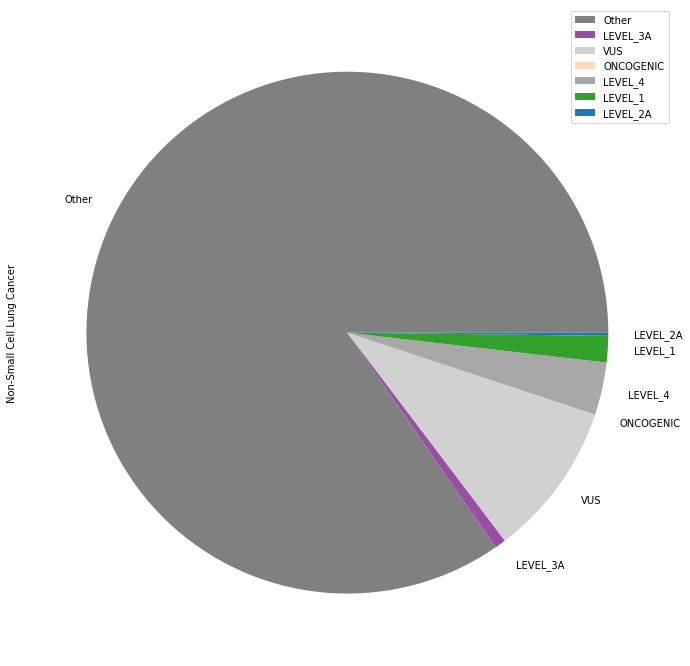

In [27]:
oncokb_level_colors = {
    'LEVEL_1': '#33A02C',
    'LEVEL_2A': '#1F78B4',
    'LEVEL_2B': '#80B1D3',
    'LEVEL_3A': '#984EA3',
    'LEVEL_3B': '#BE98CE',
    'LEVEL_4': '#a8a8a8',
    'LEVEL_R1': '#EE3424',
    'LEVEL_R2': '#F79A92',
    'LEVEL_R3': '#FCD6D3',
    'ONCOGENIC': '#ffdab9',
    'VUS': '#d1d1d1',
    'Other': 'grey'
}

cd_nsclc_level_index = []
cd_nsclc_level_colors = []
cd_nsclc_level = dict()
cd_nsclc_level['Non-Small Cell Lung Cancer'] = []

for i in msk_clinical_data_nsclc_level.items():
    cd_nsclc_level_colors.append(oncokb_level_colors[i[0]])
    cd_nsclc_level_index.append(i[0])
    cd_nsclc_level['Non-Small Cell Lung Cancer'].append(i[1])

cd_nsclc_df = pandas.DataFrame(cd_nsclc_level, index=cd_nsclc_level_index)
cd_nsclc_df.plot.pie(y='Non-Small Cell Lung Cancer', figsize=(2*plot_w, 2*plot_w), colors=cd_nsclc_level_colors)